#**Problem statement:**
 To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
#making the random picking of model consistent by setting the seed

from numpy.random import seed
seed(1)

tf.random.set_seed(2)

### **Importing Skin Cancer Data**


In [ ]:
#mounting the google drive account to read data
#any one running this file should have the dataset uploaded into their google drive 'My Drive' Folder

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Defining the path for train and test images

# Defininf the root path of the dataset
root = "/content/gdrive/My Drive/Skin-Cancer-CNN/"

#defining paths for train and test data
data_dir_train = pathlib.Path(root+"Train")
data_dir_test = pathlib.Path(root+"Test")

In [ ]:
#printing the shape of the data

image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### **Load using keras.preprocessing**

Loading these images off disk using the helpful image_dataset_from_directory utility.

#### **Creating a dataset**

Define some parameters for the loader:

In [ ]:
#defining parameters 
batch_size = 32
img_height = 180
img_width = 180
directory = root+"Train/"

Using 80% of the images for training, and 20% for validation.

In [ ]:
# defining the train dataset with image resized into 180X180 and a batch size of 32


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory,  batch_size=32, image_size=(180,
    180), shuffle=True, seed=123, validation_split=0.2, 
    subset='training', smart_resize=False
)

Found 3059 files belonging to 9 classes.
Using 2448 files for training.


In [ ]:
# defining the test dataset with the same parameters as above

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory,  batch_size=32, image_size=(180,
    180), shuffle=True, seed=123, validation_split=0.2, 
    subset='validation', smart_resize=False
)

Found 3059 files belonging to 9 classes.
Using 611 files for validation.


In [ ]:
# listing out the distinct class names 

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### **Data Visualization**


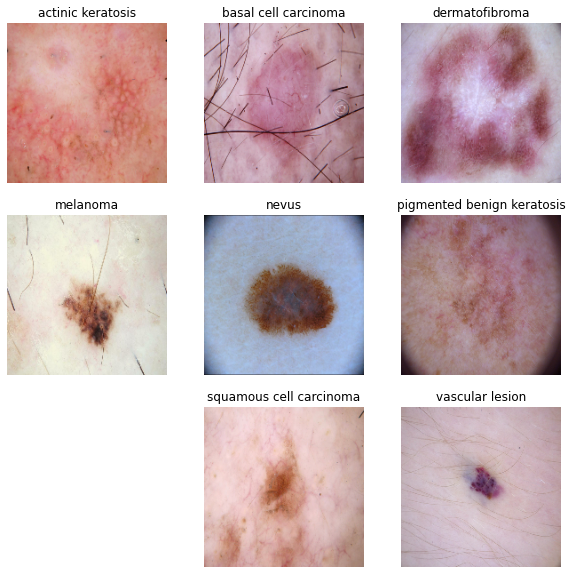

In [ ]:
# plotting a sample image from each of the 9 classes

plt.figure(figsize=(10,10))

for i in range(len(class_names)):
    filtered_ds = train_ds.filter(lambda x, l: tf.math.equal(l[0], i))
    for image, label in filtered_ds.take(1):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image[0].numpy().astype('uint8'))
        plt.title(class_names[label.numpy()[0]])
        plt.axis('off')

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### **Create the model**
#### Creating a CNN model, which can accurately detect 9 classes present in the dataset. 

In [ ]:
num_classes = 9

model = Sequential()

#adding a rescale layer where each value of the pixel is brought between 0 and 1.
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))

#Adding the first set of convolutional and pooling layer
model.add(layers.Conv2D(16, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

#Adding the second set of convolutional and pooling layer
model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

#Adding the third set of convolutional and pooling layer
model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

#Adding the Flatten layer
model.add(layers.Flatten())

#Adding the FC layers
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
layers.Dense(num_classes)

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [ ]:
### Choosing an optmizer and loss function and compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

### Train the model

In [ ]:
# Training the model with 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
77/77 [==============================] - 27s 213ms/step - loss: 1.8775 - accuracy: 0.4473 - val_loss: 1.5527 - val_accuracy: 0.5188
Epoch 2/20
77/77 [==============================] - 1s 14ms/step - loss: 1.4867 - accuracy: 0.5507 - val_loss: 1.3197 - val_accuracy: 0.6170
Epoch 3/20
77/77 [==============================] - 1s 14ms/step - loss: 1.3493 - accuracy: 0.5993 - val_loss: 1.3531 - val_accuracy: 0.6137
Epoch 4/20
77/77 [==============================] - 1s 14ms/step - loss: 1.2750 - accuracy: 0.6299 - val_loss: 1.2629 - val_accuracy: 0.6350
Epoch 5/20
77/77 [==============================] - 1s 14ms/step - loss: 1.1524 - accuracy: 0.6589 - val_loss: 1.2845 - val_accuracy: 0.6481
Epoch 6/20
77/77 [==============================] - 1s 14ms/step - loss: 1.0606 - accuracy: 0.6883 - val_loss: 1.2683 - val_accuracy: 0.6628
Epoch 7/20
77/77 [==============================] - 1s 14ms/step - loss: 0.9640 - accuracy: 0.7251 - val_loss: 1.2359 - val_accuracy: 0.6727
Epoch 8/20


### Visualizing training results

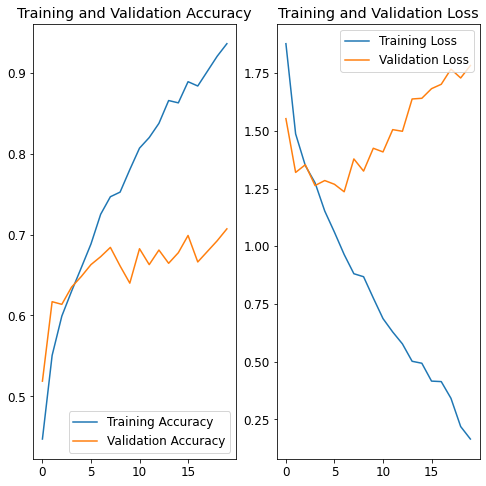

In [ ]:
# visualizing the results


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.rcParams.update({'font.size': 12})

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Observations

* The training and validation accuracy are quite far from each other which clearly shows that the model has overfitted.

* Let's add some randomization by changing the orientation of images to get some variation


In [ ]:
# Changing the oriantation by using data augumentation.


data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

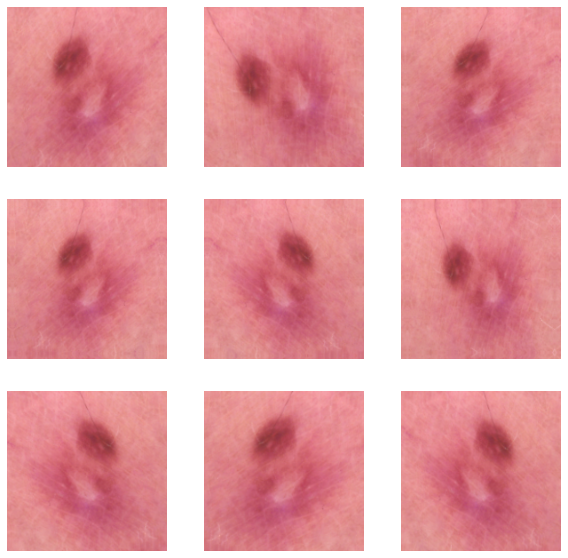

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


### Compiling the model after applying the augmentation


In [ ]:
# Adding dropouts in addition to the augmentation layer to reduce overfitting

num_classes = 9

model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))

model.add(layers.Conv2D(16, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dropout(0.25))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(128, activation='relu'))
layers.Dense(num_classes)





### Compiling the model

In [ ]:
# Compiling the model

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 45, 45, 32)       

### Training the model

In [ ]:
## Training the model with 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
77/77 [==============================] - 2s 17ms/step - loss: 2.7387 - accuracy: 0.3415 - val_loss: 2.6808 - val_accuracy: 0.4255
Epoch 2/20
77/77 [==============================] - 1s 15ms/step - loss: 1.8592 - accuracy: 0.3995 - val_loss: 2.1753 - val_accuracy: 0.4894
Epoch 3/20
77/77 [==============================] - 1s 15ms/step - loss: 1.5637 - accuracy: 0.4775 - val_loss: 1.7556 - val_accuracy: 0.5270
Epoch 4/20
77/77 [==============================] - 1s 15ms/step - loss: 1.4232 - accuracy: 0.5147 - val_loss: 1.5315 - val_accuracy: 0.5532
Epoch 5/20
77/77 [==============================] - 1s 15ms/step - loss: 1.3225 - accuracy: 0.5458 - val_loss: 1.3757 - val_accuracy: 0.5761
Epoch 6/20
77/77 [==============================] - 1s 15ms/step - loss: 1.2502 - accuracy: 0.5633 - val_loss: 1.3449 - val_accuracy: 0.5859
Epoch 7/20
77/77 [==============================] - 1s 15ms/step - loss: 1.2123 - accuracy: 0.5821 - val_loss: 1.2641 - val_accuracy: 0.5941
Epoch 8/20
77

### Visualizing the results

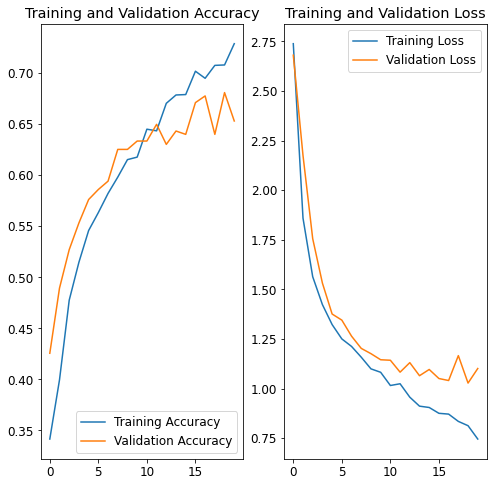

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Observations : 

* We now see significant improvement as we have overcome the problem of overfitting to a good extent.

* However, the accuracy is not so proimising and is to be worked on.

#### **Finding the distribution of classes in the training dataset.**
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

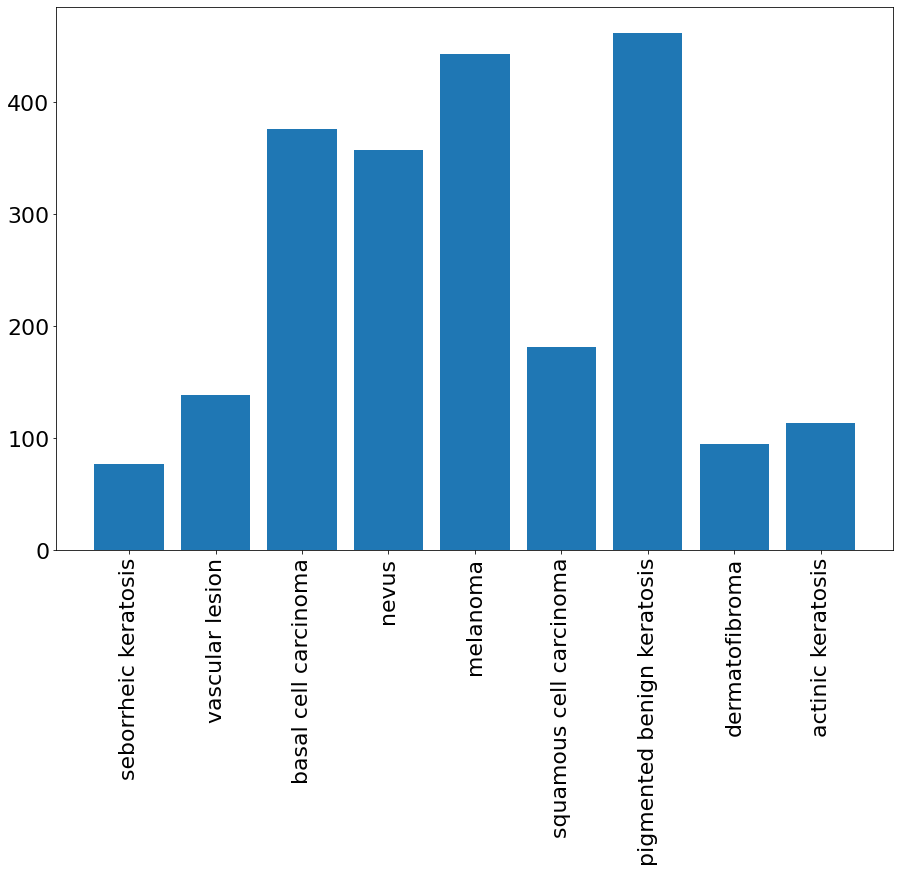

In [ ]:
# visualizing the distributing of classes

category=[]
count=[]

import os
for cls in os.listdir(directory):
  if cls=='.DS_Store':
    continue
  category.append(cls)
  count.append(len(os.listdir(directory+cls)))
  
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(15,10))
plt.bar(x=category,height=count)
plt.xticks(rotation = 90)
plt.show()
  




#### - Which class has the least number of samples? - **Seborrheic Keratosis**
#### - Which classes dominate the data in terms proportionate number of samples? - **Pigmented Benign Keratosis**


####  **Rectifying the class imbalance**


In [ ]:
!pip install Augmentor

In [ ]:
# adding 500 samples into each of the classes to get the proportions set right

path_to_training_dataset=directory
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin-Cancer-CNN/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC7C8198DD0>: 100%|██████████| 500/500 [00:09<00:00, 54.29 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin-Cancer-CNN/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FC7C808FCD0>: 100%|██████████| 500/500 [00:08<00:00, 56.22 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin-Cancer-CNN/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC7C80E39D0>: 100%|██████████| 500/500 [00:09<00:00, 54.32 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 940 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin-Cancer-CNN/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7FC7C80E4690>: 100%|██████████| 500/500 [00:52<00:00,  9.45 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin-Cancer-CNN/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7FC7C8168650>: 100%|██████████| 500/500 [00:41<00:00, 12.15 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin-Cancer-CNN/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC7D2045D90>: 100%|██████████| 500/500 [00:10<00:00, 49.05 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin-Cancer-CNN/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FC830061890>: 100%|██████████| 500/500 [00:21<00:00, 22.94 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin-Cancer-CNN/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FC7C81CB590>: 100%|██████████| 500/500 [00:09<00:00, 50.68 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin-Cancer-CNN/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FC7C80FFB10>: 100%|██████████| 500/500 [00:09<00:00, 52.58 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4410


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/My Drive/Skin-Cancer-CNN/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011126.jpg_3a82e3be-88f0-4265-98f5-b4eb534b7bbd.jpg',
 '/content/gdrive/My Drive/Skin-Cancer-CNN/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011052.jpg_6d122618-5703-452d-9b52-41d11e54ec9b.jpg',
 '/content/gdrive/My Drive/Skin-Cancer-CNN/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011181.jpg_e07542d6-1a2d-4c0c-9a4f-414c64d46668.jpg',
 '/content/gdrive/My Drive/Skin-Cancer-CNN/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011130.jpg_e476647b-dc66-42f3-9182-f1e3b88bec66.jpg',
 '/content/gdrive/My Drive/Skin-Cancer-CNN/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011130.jpg_ad0913fc-da05-4fc6-9d11-e1522027657f.jpg',
 '/content/gdrive/My Drive/Skin-Cancer-CNN/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010909.jpg_abc36956-d357-4915-be44-0087020cf0a8.jpg'

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',


In [ ]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
df2['Label'].value_counts()

vascular lesion               500
basal cell carcinoma          500
dermatofibroma                500
actinic keratosis             500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
melanoma                      410
Name: Label, dtype: int64

In [ ]:
old_path_list = [x for x in glob(os.path.join(data_dir_train, '*','*.jpg'))]

lesion_list_old = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*','*.jpg'))]

dataframe_dict_old = dict(zip(old_path_list, lesion_list_old))

df1 = pd.DataFrame(list(dataframe_dict_old.items()),columns = ['Path','Label'])

df1['Label'].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

In [ ]:
# creating a new dataframe to visualize the sample size in each class after adding the 500 samples in each class

new_df = df1.append(df2)
new_df['Label'].value_counts()

pigmented benign keratosis    962
basal cell carcinoma          876
nevus                         857
melanoma                      848
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
#setting up the parameters

batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:
#setting the train data after the sample addition

data_train_dir = root+"Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8189 files belonging to 9 classes.
Using 6552 files for training.


#### **Todo:** Create a validation dataset

In [ ]:
#setting the validation data after the sample addition


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8189 files belonging to 9 classes.
Using 1637 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
## creating a third model with the new data set and slightly modified dropouts



num_classes = 9

model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))

model.add(layers.Conv2D(16, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(128, activation='relu'))
layers.Dense(num_classes)



#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
## compiling the model

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 45, 45, 32)       

#### **Todo:**  Train your model

In [ ]:
# Training the model with 30 epochs

epochs = 30

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
205/205 [==============================] - 117s 549ms/step - loss: 3.1298 - accuracy: 0.2784 - val_loss: 3.5810 - val_accuracy: 0.3537
Epoch 2/30
205/205 [==============================] - 27s 128ms/step - loss: 2.4932 - accuracy: 0.3996 - val_loss: 2.6565 - val_accuracy: 0.4582
Epoch 3/30
205/205 [==============================] - 26s 125ms/step - loss: 2.2794 - accuracy: 0.4771 - val_loss: 2.5688 - val_accuracy: 0.4783
Epoch 4/30
205/205 [==============================] - 27s 130ms/step - loss: 2.1684 - accuracy: 0.5003 - val_loss: 2.2718 - val_accuracy: 0.5168
Epoch 5/30
205/205 [==============================] - 26s 125ms/step - loss: 1.9464 - accuracy: 0.5217 - val_loss: 1.9451 - val_accuracy: 0.5150
Epoch 6/30
205/205 [==============================] - 27s 128ms/step - loss: 1.3152 - accuracy: 0.5476 - val_loss: 1.3324 - val_accuracy: 0.5724
Epoch 7/30
205/205 [==============================] - 26s 125ms/step - loss: 1.1531 - accuracy: 0.5806 - val_loss: 1.1793 - val_a

#### **Todo:**  Visualize the model results

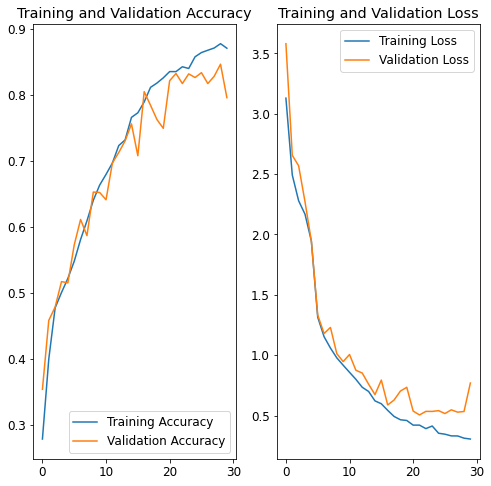

In [ ]:
#visualizing the model results

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)


plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## **Analysis**

1. The the accuracy certainly improved after rebalancing the train data set from 64 to 87

2. The overfitting although isn't the best but has certainly improved from the last mode.

3. We can add more convolutional and FC layers to get more accurate and reliable model

